# LinkedIn Job Postings

## ADS 508 Impacting the Business with a Distributed Data Science Pipeline

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from pyathena import connect
import awswrangler as wr
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### CSV to S3

In [2]:
# Setup boto3 session parameters
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Establish connection
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
# Set S3 Source Location (Public bucket)
s3_public_path = "s3://linkedin-postings"

In [4]:
%store s3_public_path

Stored 's3_public_path' (str)


In [5]:
# Set S3 Destination Location (Private bucket)
s3_private_path = "s3://{}/linkedin_data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-937572952481/linkedin_data


In [6]:
%store s3_private_path

Stored 's3_private_path' (str)


In [7]:
# Copy data from Public S3 bucket to Private S3 bucket
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "postings/postings.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "salaries/salaries.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "job_skills/job_skills.csv"

copy: s3://linkedin-postings/postings/postings.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/postings/postings.csv
copy: s3://linkedin-postings/salaries/salaries.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/salaries/salaries.csv
copy: s3://linkedin-postings/job_skills/job_skills.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/job_skills/job_skills.csv


In [8]:
# Check files are copied successfully to private bucket
!aws s3 ls $s3_private_path/

                           PRE job_skills/
                           PRE partition/
                           PRE postings/
                           PRE salaries/


In [9]:
# Initialize boto3 client
s3 = boto3.client('s3')

# Define bucket and paths 
bucket_name = bucket
file_key = 'linkedin_data/postings/postings.csv'
cleaned_file_key = 'linkedin_data/postings/cleaned/cleaned_postings.csv'

# Read postings.csv directly from private bucket
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df = pd.read_csv(obj['Body'])

# Remove embedded newlines
df['description'].replace({r'[\n\r]+': ' '}, regex=True, inplace=True)
df['description'].replace({r'[,]+': ' '}, regex=True, inplace=True)
df['skills_desc'].replace({r'[\n\r]+': ' '}, regex=True, inplace=True)
df['skills_desc'].replace({r'[,]+': ' '}, regex=True, inplace=True)

# Save cleaned CSV back to S3 directly (in-memory)
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)

s3.put_object(Bucket=bucket_name, Key=cleaned_file_key, Body=csv_buffer.getvalue())

print(f"Cleaned CSV successfully uploaded to: s3://{bucket_name}/{cleaned_file_key}")


Cleaned CSV successfully uploaded to: s3://sagemaker-us-east-1-937572952481/linkedin_data/postings/cleaned/cleaned_postings.csv


### Create Athena Database 

In [10]:
ingest_create_athena_db_passed = False

In [11]:
ingest_create_athena_table_passed = False

In [12]:
database_name = "linkedin_data"

In [13]:
# Set S3 staging directory - a temporary directory for Athena queries
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [14]:
# Connect to staging directory
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [15]:
# Create Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


### Verify database has been created

In [16]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,linkedin_data
3,sagemaker_featurestore


In [17]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena Tables from CSV Files

In [18]:
table_name = 'postings'
postings_path = "s3://{}/linkedin_data/postings/cleaned/".format(bucket)

drop_statement = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name)

print(drop_statement)
pd.read_sql(drop_statement, conn)
print("Attempted to Drop {} table".format(table_name))

DROP TABLE IF EXISTS linkedin_data.postings;
Attempted to Drop postings table


In [19]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        company_name string,
        title string,
        description string,
        max_salary float,
        pay_period string,
        location string,
        company_id float,
        views float,
        med_salary float,
        min_salary float,
        formatted_work_type string,
        applies float,
        original_listed_time float,
        remote_allowed float,
        job_posting_url string,
        application_url string,
        application_type string,
        expiry float,
        closed_time float,
        formatted_experience_level string,
        skills_desc string,
        listed_time string,
        posting_domain string,
        sponsored int,
        work_type string,
        currency string,
        compensation_type string,
        normalized_salary float,
        zip_code int,
        fips int
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, postings_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created postings table")

Created postings table


In [20]:
table_name_2 = "salaries"
salaries_path = "s3://{}/linkedin_data/salaries/".format(bucket)

drop_statement2 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_2)

print(drop_statement2)
pd.read_sql(drop_statement2, conn)
print("Attempted to Drop {} table".format(table_name_2))

DROP TABLE IF EXISTS linkedin_data.salaries;
Attempted to Drop salaries table


In [21]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        salary_id int,
        job_id string,
        max_salary float,
        med_salary float,
        min_salary float,
        pay_period string,
        currency string,
        compensation_type string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_2, salaries_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created salaries table")

Created salaries table


In [22]:
table_name_3 = "job_skills"
job_skills_path = "s3://{}/linkedin_data/job_skills/".format(bucket)

drop_statement3 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_3)

print(drop_statement3)
pd.read_sql(drop_statement3, conn)
print("Attempted to Drop {} table".format(table_name_3))

DROP TABLE IF EXISTS linkedin_data.job_skills;
Attempted to Drop job_skills table


In [23]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        skill_abr string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_3, job_skills_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created job_skills table")

Created job_skills table


### Verify tables have been created successfully

In [24]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,job_skills
1,postings
2,salaries


In [25]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [26]:
# View postings table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name)

pd.read_sql(statement, conn)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"""Princeton",None,2774458.0,20.0,...,,Requirements: We are seeking a College or Gra...,1713397508000.0,None,0,FULL_TIME,USD,None,38480.0,8540
1,1829192,,Mental Health Therapist/Counselor,At Aspen Therapy and Wellness we are committ...,50.0,HOURLY,"""Fort Collins",None,NaN,1.0,...,,,1712857887000.0,None,0,FULL_TIME,USD,None,83200.0,80521
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"""Cincinnati",None,64896720.0,8.0,...,,We are currently accepting resumes for FOH - A...,1713277614000.0,None,0,FULL_TIME,USD,None,55000.0,45202
3,23221523,"""Abrams Fensterman","LLP""",Senior Elder Law / Trusts and Estates Associat...,NaN,175000.0,YEARLY,None,NaN,766262.0,...,,,This position requires a baseline understandin...,None,,0,FULL_TIME,None,NaN,157500
4,35982263,,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"""Burlington",None,NaN,3.0,...,,,1713451943000.0,None,0,FULL_TIME,USD,None,70000.0,52601


In [27]:
# View salaries table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_2)

pd.read_sql(statement, conn)

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


## Create Athena Parquet Tables from CSV

### Postings Table

In [28]:
table_name_parquet = "postings"
postings_parquet_path = "s3://{}/linkedin_data/parquet/postings/".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT job_id,
        company_name,
        title,
        description,
        max_salary,
        pay_period,
        location,
        company_id,
        views,
        med_salary,
        min_salary,
        formatted_work_type,
        applies,
        original_listed_time,
        remote_allowed,
        job_posting_url,
        application_url,
        application_type,
        expiry,
        closed_time,
        formatted_experience_level,
        skills_desc,
        listed_time,
        posting_domain,
        sponsored,
        work_type,
        currency,
        compensation_type,
        normalized_salary,
        zip_code,
        fips
FROM {}.{}""".format(
    database_name, table_name_parquet, postings_parquet_path, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


### Salaries table

In [29]:
table_name_parquet2 = "salaries"
salaries_parquet_path = "s3://{}/linkedin_data/parquet/salaries/".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT salary_id,
    job_id,
    max_salary,
    med_salary,
    min_salary,
    pay_period,
    currency,
    compensation_type
FROM {}.{}""".format(
    database_name, table_name_parquet2, salaries_parquet_path, database_name, table_name_2
)


pd.read_sql(statement, conn)

,rows


### Job Skills table

In [30]:
table_name_parquet3 = "job_skills"
job_skills_parquet_path = "s3://{}/linkedin_data/parquet/job_skills/".format(bucket)

# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT job_id,
        skill_abr
FROM {}.{}""".format(
    database_name, table_name_parquet3, job_skills_parquet_path, database_name, table_name_3
)

pd.read_sql(statement, conn)

,rows


## Data Exploration

In [31]:
# View job skills table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_3)

pd.read_sql(statement, conn)

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


In [32]:
postings_df = wr.athena.read_sql_query("""SELECT * FROM postings""", database=database_name)

2025-04-01 04:18:28,132	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1895804928 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.53gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-04-01 04:18:28,336	INFO worker.py:1786 -- Started a local Ray instance.


In [33]:
salaries_df = wr.athena.read_sql_query("""SELECT * FROM salaries""", database=database_name)

In [34]:
job_skills_df = wr.athena.read_sql_query("""SELECT * FROM job_skills""", database=database_name)

### postings EDA

In [35]:
# Basic info
postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  string 
 1   company_name                123849 non-null  string 
 2   title                       123849 non-null  string 
 3   description                 123849 non-null  string 
 4   max_salary                  24318 non-null   float32
 5   pay_period                  123849 non-null  string 
 6   location                    123849 non-null  string 
 7   company_id                  10990 non-null   float32
 8   views                       101004 non-null  float32
 9   med_salary                  108787 non-null  float32
 10  min_salary                  28915 non-null   float32
 11  formatted_work_type         123849 non-null  string 
 12  applies                     9650 non-null    float32
 13  original_liste

In [36]:
# Missing values
postings_df.isnull().sum()

job_id                             0
company_name                       0
title                              0
description                        0
max_salary                     99531
pay_period                         0
location                           0
company_id                    112859
views                          22845
med_salary                     15062
min_salary                     94934
formatted_work_type                0
applies                       114199
original_listed_time           96579
remote_allowed                 22178
job_posting_url                    0
application_url                    0
application_type                   0
expiry                        112359
closed_time                    32571
formatted_experience_level         0
skills_desc                        0
listed_time                        0
posting_domain                     0
sponsored                     112516
work_type                          0
currency                           0
c

In [37]:
# Duplicates
duplicates = postings_df.duplicated().sum()
print(duplicates)

0


In [38]:
# Summary statistics for numerical columns
print(postings_df.describe())

         max_salary   company_id        views    med_salary    min_salary  \
count  2.431800e+04      10990.0     101004.0  1.087870e+05  2.891500e+04   
mean   8.681276e+04   23440146.0   10326367.0  1.540251e+06  6.099948e+05   
std    7.743168e+05   34722760.0   23558464.0  9.642650e+06  5.935861e+06   
min    1.000000e+00         15.5          1.0  0.000000e+00  0.000000e+00   
25%    4.500000e+01     128505.0       6636.0  4.000000e+00  4.000000e+00   
50%    7.500000e+04    2632918.0     157338.0  5.000000e+00  9.000000e+00   
75%    1.300000e+05   35503864.0    3570660.0  2.000000e+01  5.500000e+01   
max    1.200000e+08  103456464.0  103472976.0  1.034588e+08  1.033847e+08   

            applies  original_listed_time  remote_allowed        expiry  \
count  9.650000e+03          2.727000e+04    1.016710e+05  1.149000e+04   
mean   9.915842e+04          7.119720e+11    1.535486e+12  1.708869e+12   
std    1.985724e+06          8.443095e+11    5.223090e+11  1.163866e+11   
min   

In [39]:
# Top 10 unique values in categorical columns
categorical = ["title", "company_name", "location", "formatted_work_type", "formatted_experience_level"]
for col in categorical:
    print(postings_df[col].value_counts().head(10))

title
 Inc."                             4908
 LLC"                              1412
Sales Manager                       669
 Inc"                               648
"Manager                            531
"Director                           528
Project Manager                     318
Customer Service Representative     315
"Senior Manager                     280
Administrative Assistant            234
Name: count, dtype: Int64
company_name
                                                  1719
Liberty Healthcare and Rehabilitation Services    1108
The Job Network                                   1003
J. Galt                                            604
TEKsystems                                         529
"Lowe's Companies                                  527
Ingersoll Rand                                     517
Capital One                                        496
Cogent Communications                              476
Insight Global                                     418
Name:

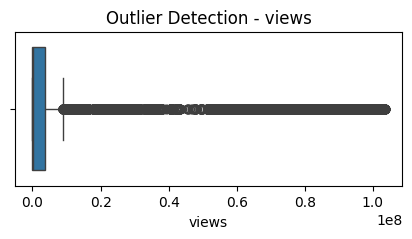

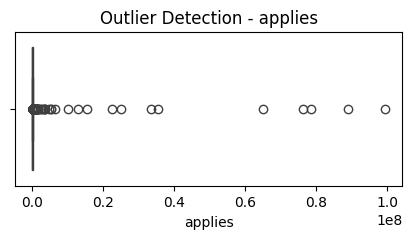

In [40]:
# Detect Outliers using box plots
numerical = ["views", "applies"]
for col in numerical:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=postings_df[col])
    plt.title(f"Outlier Detection - {col}")
    plt.show()

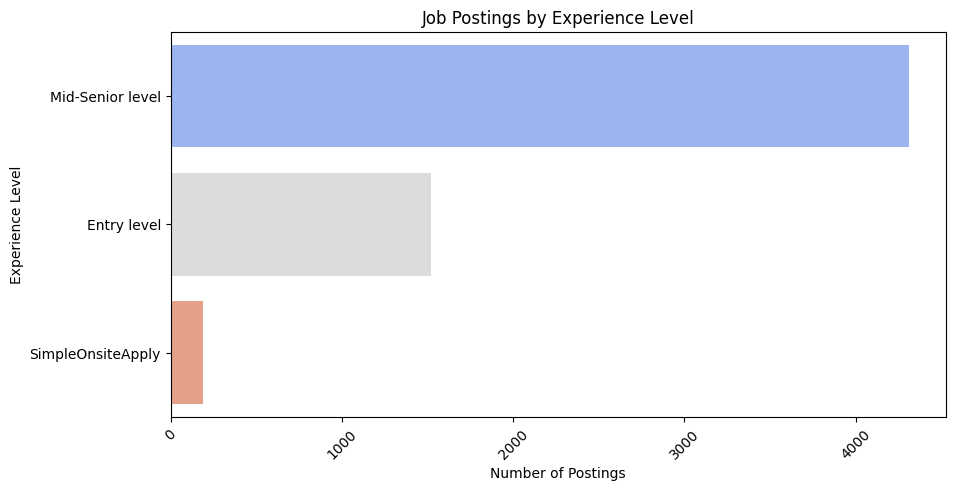

In [41]:
# Visualize experience level distribution
top_titles = postings_df["formatted_experience_level"].value_counts().iloc[[1,3,7]]

plt.figure(figsize=(10,5))
sns.barplot(y=top_titles.index, x=top_titles.values, palette="coolwarm")
plt.xlabel("Number of Postings")
plt.ylabel("Experience Level")
plt.title("Job Postings by Experience Level")
plt.xticks(rotation=45)
plt.show()

### salaries EDA

In [42]:
# Basic stats
print(salaries_df.describe())
print(salaries_df.info())

          salary_id    max_salary     med_salary    min_salary
count       40785.0  3.394700e+04    6838.000000  3.394700e+04
mean        20393.0  9.620987e+04   21370.296875  6.508541e+04
std    11773.759701  6.587374e+05   51338.566406  4.650612e+05
min             1.0  1.000000e+00       0.000000  1.000000e+00
25%         10197.0  5.000000e+01      18.500000  3.900000e+01
50%         20393.0  8.500000e+04      25.000000  6.230000e+04
75%         30589.0  1.425000e+05    2207.000000  1.000000e+05
max         40785.0  1.200000e+08  750000.000000  8.500000e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40785 entries, 0 to 40784
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          40785 non-null  Int32  
 1   job_id             40785 non-null  string 
 2   max_salary         33947 non-null  float32
 3   med_salary         6838 non-null   float32
 4   min_salary         33947 non-nul

In [43]:
# Missing values
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [44]:
# Duplicates
salaries_df.duplicated().sum()

0

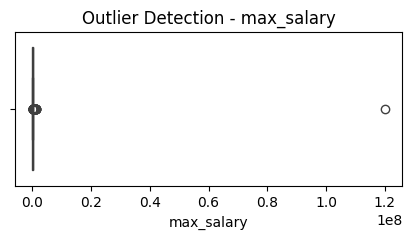

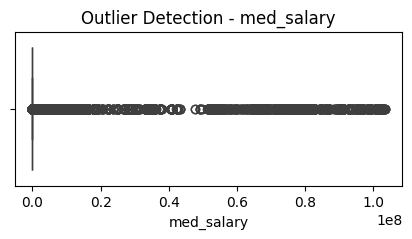

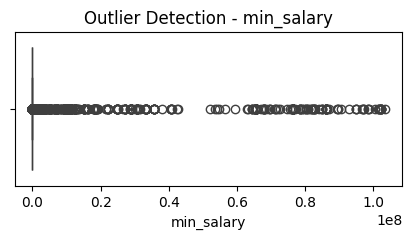

In [45]:
# Detect Outliers using box plots
numerical = ["max_salary", "med_salary", "min_salary"]
for col in numerical:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=postings_df[col])
    plt.title(f"Outlier Detection - {col}")
    plt.show()

In [46]:
# Salary distributions
salary_columns = ["min_salary", "med_salary", "max_salary"]
print(salaries_df[salary_columns].describe())

         min_salary     med_salary    max_salary
count  3.394700e+04    6838.000000  3.394700e+04
mean   6.508541e+04   21370.296875  9.620987e+04
std    4.650612e+05   51338.566406  6.587374e+05
min    1.000000e+00       0.000000  1.000000e+00
25%    3.900000e+01      18.500000  5.000000e+01
50%    6.230000e+04      25.000000  8.500000e+04
75%    1.000000e+05    2207.000000  1.425000e+05
max    8.500000e+07  750000.000000  1.200000e+08


array([[<Axes: title={'center': 'salary_id'}>,
        <Axes: title={'center': 'max_salary'}>],
       [<Axes: title={'center': 'med_salary'}>,
        <Axes: title={'center': 'min_salary'}>]], dtype=object)

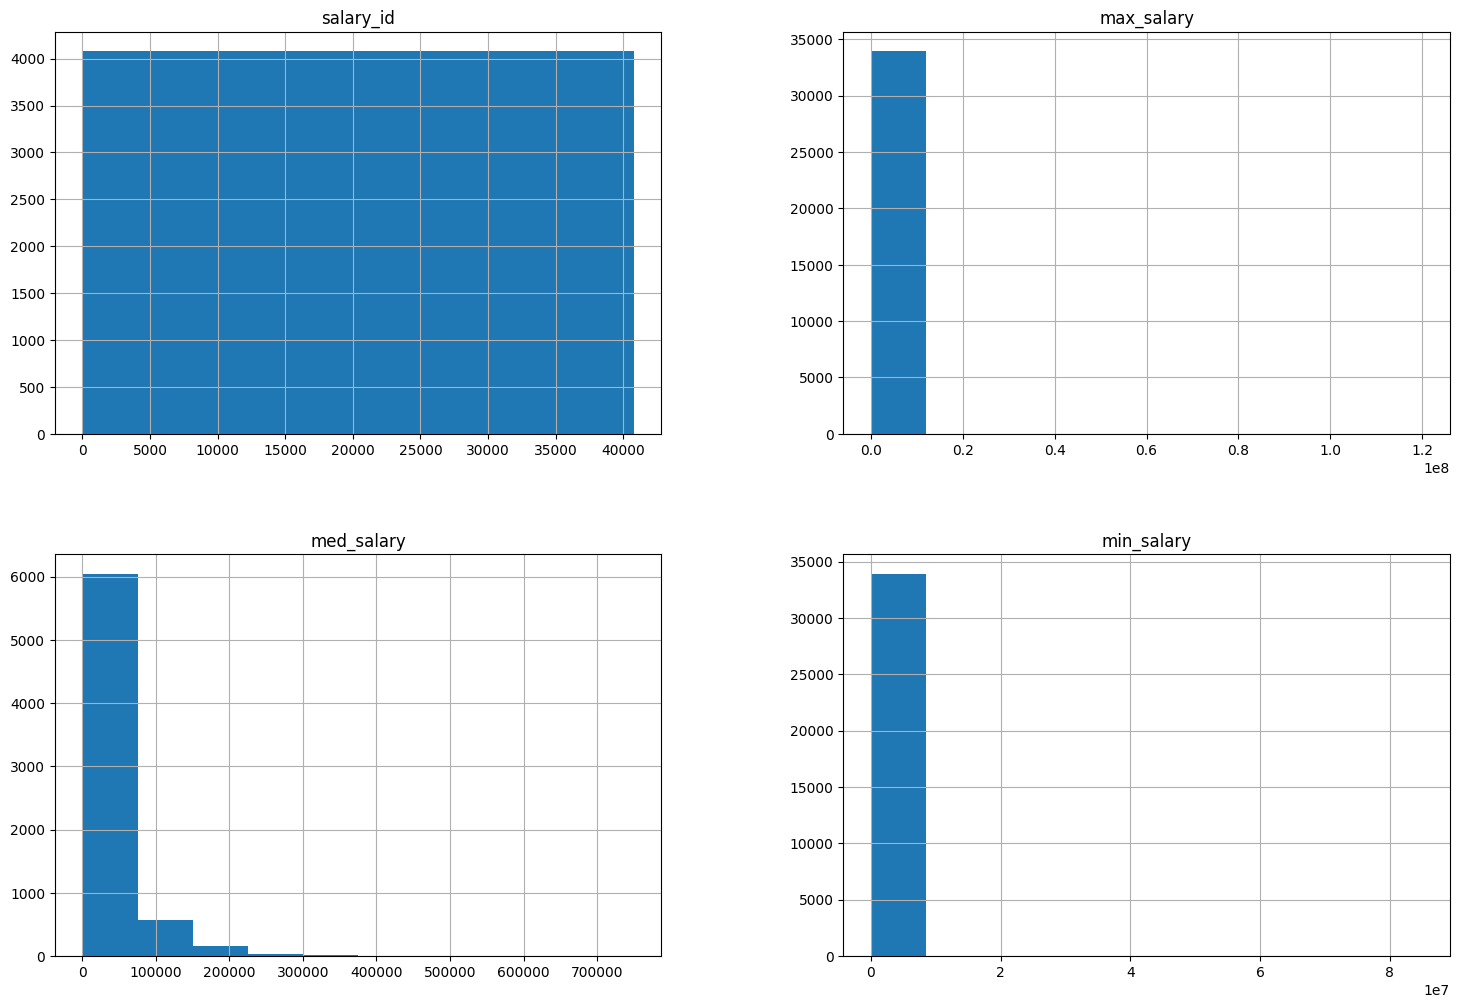

In [47]:
salaries_df.hist(figsize=(18,12))

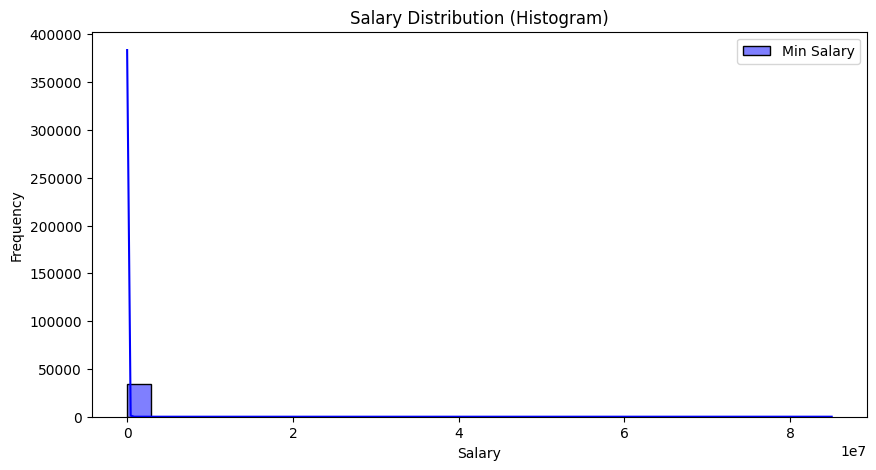

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["min_salary"], color="blue", kde=True, label="Min Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

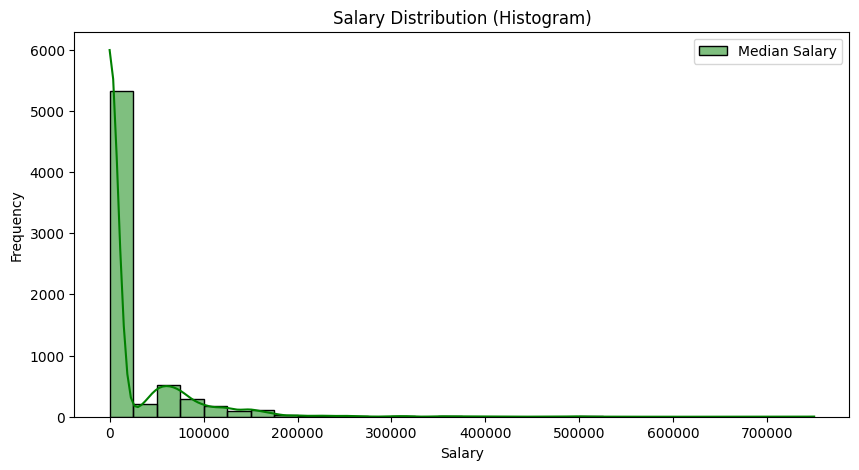

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["med_salary"], color="green", kde=True, label="Median Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

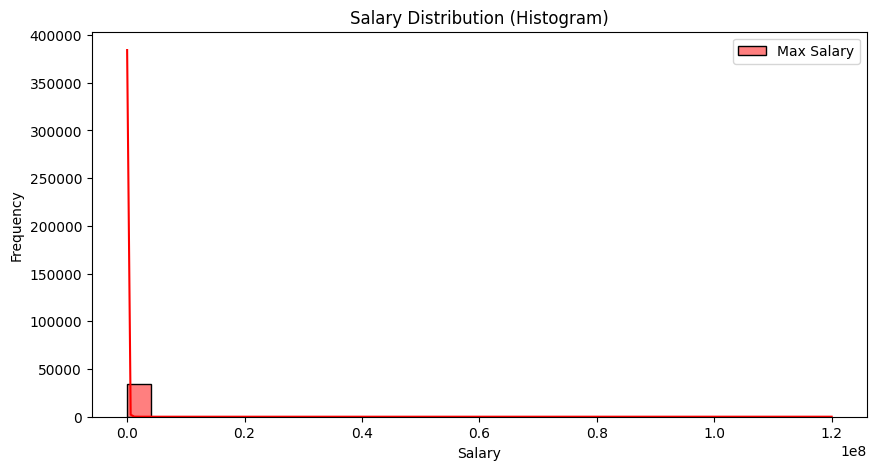

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["max_salary"], color="red", kde=True, label="Max Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### job_skills EDA

In [51]:
# Basic info
print(job_skills_df.describe())
print(job_skills_df.info())

            job_id skill_abr
count       213768    213768
unique      126807        35
top     3693083161        IT
freq             3     26137
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213768 entries, 0 to 213767
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   job_id     213768 non-null  string
 1   skill_abr  213768 non-null  string
dtypes: string(2)
memory usage: 3.3 MB
None


In [52]:
# Missing values
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [53]:
# Duplicates
job_skills_df.duplicated().sum()

0

In [54]:
# Unique skills
print(f"Unique Job Skills: {job_skills_df['skill_abr'].nunique()}")

Unique Job Skills: 35


In [55]:
# Skill frequencies
job_skills_df["skill_abr"] = job_skills_df["skill_abr"].astype(str)  # Ensure it's a string
skills = job_skills_df["skill_abr"].str.split(",").explode().str.strip().value_counts()
print(skills.head(20))

skill_abr
IT      26137
SALE    22475
MGMT    20861
MNFC    18185
HCPR    17369
BD      14290
ENG     13009
OTHR    12608
FIN      8540
MRKT     5525
ACCT     5461
ADM      4860
CUST     4292
PRJM     3997
ANLS     3858
RSCH     2986
HR       2647
LGL      2371
CNSL     2338
EDU      2290
Name: count, dtype: int64


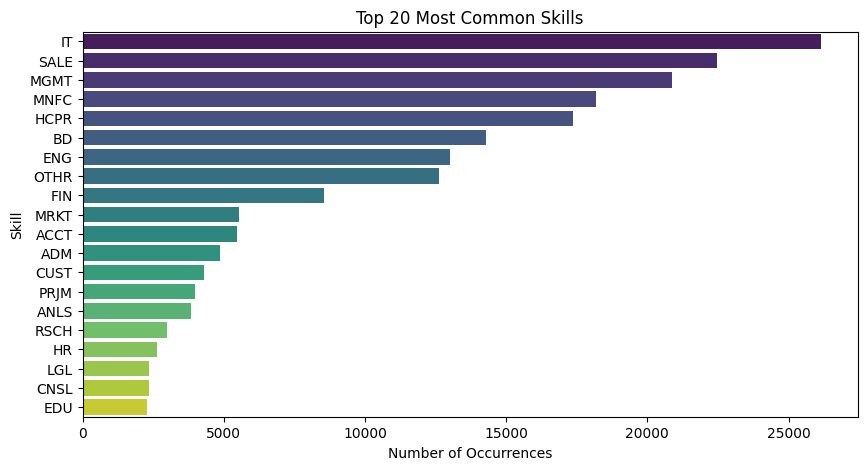

In [56]:
# Concatenate all skills descriptions
all_skills = " ".join(job_skills_df["skill_abr"].dropna())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_skills)

# Bar Chart of Top 20 Most Common Skills
top_skills = skills.head(20)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_skills.index, x=top_skills.values, palette="viridis")
plt.title("Top 20 Most Common Skills")
plt.xlabel("Number of Occurrences")
plt.ylabel("Skill")
plt.show()

### Pre-Processing

In [57]:
# Missing values - postings_df
postings_df.isnull().sum()

job_id                             0
company_name                       0
title                              0
description                        0
max_salary                     99531
pay_period                         0
location                           0
company_id                    112859
views                          22845
med_salary                     15062
min_salary                     94934
formatted_work_type                0
applies                       114199
original_listed_time           96579
remote_allowed                 22178
job_posting_url                    0
application_url                    0
application_type                   0
expiry                        112359
closed_time                    32571
formatted_experience_level         0
skills_desc                        0
listed_time                        0
posting_domain                     0
sponsored                     112516
work_type                          0
currency                           0
c

In [58]:
# Missing values - salaries_df
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [59]:
# Missing values - job_skills_df
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [60]:
# Romove unnecessary columns
columns_to_keep = ['job_id', 'title', 'description', 'max_salary', 'pay_period', 'location', 'remote_allowed', 'min_salary', 'formatted_experience_level', 'formatted_work_type', 'med_salary', 'work_type', 'zip_code']
postings_df = postings_df[columns_to_keep]

In [61]:
postings_df.head()

,job_id,title,description,max_salary,pay_period,location,remote_allowed,min_salary,formatted_experience_level,formatted_work_type,med_salary,work_type,zip_code
0,3903884219,Housekeeper,Work With Purpose At Five Star Senior Living ...,NaN,,"""Winchester",1.713498e+12,NaN,,,4.0,0,<NA>
1,3903884227,Waiter/Server,Work With Purpose At Five Star Senior Living ...,NaN,,"""Raleigh",1.713498e+12,NaN,,,4.0,0,<NA>
2,3903884229,Waiter/Server,Work With Purpose At Five Star Senior Living ...,NaN,,"""West Palm Beach",1.713498e+12,NaN,,,4.0,0,<NA>
3,3903884315,General Labor,When we win you win! UFP has a long history o...,NaN,,"""Hillsboro",1.713498e+12,NaN,,,3.0,0,<NA>
4,3903884462,Patient Services Representative PRN,"""Description Introduction Do you have the PRN ...",NaN,,"""Hermitage",1.713498e+12,NaN,,,4.0,0,<NA>


In [62]:
# Filter for U.S. postings only
us_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
    ]

def us_location(location):
    if pd.isna(location):  # Handle NaN values
        return False
    
    parts = [part.strip() for part in location.split(',')]  # Split by comma and clean spaces
    
    if any(part.lower() in ['usa', 'united states'] for part in parts):
        return True
    
    if any(part in us_states for part in parts):
        return True
    
    return False

postings_df = postings_df[postings_df['location'].apply(us_location)]

In [63]:
# Fill NaN with median of respective column
postings_df['max_salary'].fillna(postings_df['max_salary'].median(), inplace=True)
postings_df['min_salary'].fillna(postings_df['min_salary'].median(), inplace=True)
postings_df['med_salary'].fillna(postings_df['med_salary'].median(), inplace=True)

In [64]:
# Ensure there are no incorrect data types for salaries
postings_df['max_salary'] = pd.to_numeric(postings_df['max_salary'], errors='coerce')
postings_df['min_salary'] = pd.to_numeric(postings_df['min_salary'], errors='coerce')
postings_df['med_salary'] = pd.to_numeric(postings_df['med_salary'], errors='coerce')

In [65]:
# Remove missing values in pay_period column
postings_df = postings_df.dropna(subset=['pay_period'])

In [66]:
# Fill in empty cells with 0 for remote NOT allowed
postings_df['remote_allowed'].fillna(0, inplace=True)

In [67]:
# Fill NaN with the most common experience level
postings_df['formatted_experience_level'].fillna(postings_df['formatted_experience_level'].mode()[0], inplace=True)

In [68]:
# Removed .0 at the end of all zipcodes and filled NaN with 0
postings_df['zip_code'] = postings_df['zip_code'].fillna(0).astype(int).astype(str)

In [69]:
# Double check df looks right
postings_df.info()
postings_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 6870 entries, 24 to 123820
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      6870 non-null   string 
 1   title                       6870 non-null   string 
 2   description                 6870 non-null   string 
 3   max_salary                  6870 non-null   float32
 4   pay_period                  6870 non-null   string 
 5   location                    6870 non-null   string 
 6   remote_allowed              6870 non-null   float32
 7   min_salary                  6870 non-null   float32
 8   formatted_experience_level  6870 non-null   string 
 9   formatted_work_type         6870 non-null   string 
 10  med_salary                  6870 non-null   float32
 11  work_type                   6870 non-null   string 
 12  zip_code                    6870 non-null   object 
dtypes: float32(4), object(1), string(8)

job_id                        0
title                         0
description                   0
max_salary                    0
pay_period                    0
location                      0
remote_allowed                0
min_salary                    0
formatted_experience_level    0
formatted_work_type           0
med_salary                    0
work_type                     0
zip_code                      0
dtype: int64

In [70]:
# Fill NaN with median of respective column
salaries_df['max_salary'].fillna(salaries_df['max_salary'].median(), inplace=True)
salaries_df['min_salary'].fillna(salaries_df['min_salary'].median(), inplace=True)
salaries_df['med_salary'].fillna(salaries_df['med_salary'].median(), inplace=True)

In [71]:
# Ensure there are no incorrect data types for salaries
salaries_df['max_salary'] = pd.to_numeric(salaries_df['max_salary'], errors='coerce')
salaries_df['min_salary'] = pd.to_numeric(salaries_df['min_salary'], errors='coerce')
salaries_df['med_salary'] = pd.to_numeric(salaries_df['med_salary'], errors='coerce')

In [77]:
# Inner join all dfs for modeling?
# df = postings_df.merge(job_skills_df, on='job_id', how='inner')
# df = df.merge(salaries_df, on='job_id', how='inner')

In [78]:
#import os
#print(os.listdir('.'))


['.git', '.gitignore', 'README.md', '.ipynb_checkpoints', 'Setup', 'ADS_508_Final_Notebook.ipynb', 'Dependencies.ipynb', 'postings.csv']


In [79]:
#import pandas as pd

#df = pd.read_csv('postings.csv')
#print(df.info())
#print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23658 entries, 0 to 23657
Columns: 7003 entries, job_id to remote_allowed_1.0
dtypes: bool(995), float64(2), int64(1), object(6005)
memory usage: 1.1+ GB
None
     job_id                                              title     pca_1  \
0    921716                              Marketing Coordinator  0.180085   
1   1829192                  Mental Health Therapist/Counselor -0.307966   
2  10998357                        Assitant Restaurant Manager  0.198053   
3  23221523  Senior Elder Law / Trusts and Estates Associat... -0.059005   
4  35982263                                 Service Technician -0.176762   

      pca_2  zip_code_0  zip_code_10001  zip_code_1001  zip_code_1002  \
0  0.171663       False           False          False          False   
1 -0.039841       False           False          False          False   
2  0.219489       False           False          False          False   
3  0.215824       False           False   

In [80]:
from sklearn.model_selection import train_test_split

# Step 1: 80% train, 20% temp
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Split the remaining 20% evenly
df_validate, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Confirm the splits
print("Train shape:", df_train.shape)
print("Validate shape:", df_validate.shape)
print("Test shape:", df_test.shape)


Train shape: (18926, 7003)
Validate shape: (2366, 7003)
Test shape: (2366, 7003)


In [81]:
import boto3
from io import StringIO

# Use your private bucket from earlier
s3 = boto3.client('s3')
bucket_name = bucket  # this should already be set
base_path = 'linkedin_data/partition'

# Upload helper function
def upload_df_to_s3(df, key):
    buffer = StringIO()
    df.to_csv(buffer, index=False)
    s3.put_object(Bucket=bucket_name, Key=key, Body=buffer.getvalue())
    print(f"✅ Uploaded to s3://{bucket_name}/{key}")

# Upload each partition
upload_df_to_s3(df_train, f'{base_path}/train/train.csv')
upload_df_to_s3(df_validate, f'{base_path}/validate/validate.csv')
upload_df_to_s3(df_test, f'{base_path}/test/test.csv')


✅ Uploaded to s3://sagemaker-us-east-1-445732154141/linkedin_data/postings/train/train.csv
✅ Uploaded to s3://sagemaker-us-east-1-445732154141/linkedin_data/postings/validate/validate.csv
✅ Uploaded to s3://sagemaker-us-east-1-445732154141/linkedin_data/postings/test/test.csv


In [82]:
#rm postings.csv


### Model Training

In [193]:
# Load from S3 into pandas
s3 = boto3.client('s3')
obj = s3.get_object(
    Bucket= session.default_bucket(),
    Key='linkedin_data/partition/train/train.csv'
)
df = pd.read_csv(obj['Body'])

# Convert to NumPy
train_np = df.to_numpy()

# Record shape
num_records = train_np.shape[0]
feature_dim = train_np.shape[1]

print("Training shape:", train_np.shape)


Training shape: (99079, 31)


In [195]:
# Your preprocessing
df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])
train_np = df_numeric.astype('float32').to_numpy()

# 🔽 Insert this
from sagemaker.image_uris import retrieve
from sagemaker import KMeans

container = retrieve('kmeans', region=region)

kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    k=5,
    output_path=f's3://{bucket}/output/kmeans/',
    sagemaker_session=session,
    image_uri=container
)

# Now this will work
train_data = kmeans.record_set(train_np)
kmeans.fit(train_data)


[04/01/25 04:05:03] INFO     Same images used for training and inference. Defaulting to image     ]8;id=802727;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=363844;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=424837;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=600293;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

[04/01/25 04:05:04] INFO     Same images used for training and inference. Defaulting to image     ]8;id=519661;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=298043;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=553262;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=569056;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:23                                                                                   │
│                                                                                                  │
│   20                                                                                             │
│   21 # Now this will work                                                                        │
│   22 train_data = kmeans.record_set(train_np)                                                    │
│ ❱ 23 kmeans.fit(train_data)                                                                      │
│   24                                                                                             │
│                                                                                                  │
│ in wrapper:346                                                                                   │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/amazon/amazon_estimator.py:265 in fit          │
│                                                                                                  │
│   262 │   │   │   train (numpy.ndarray): A 2D numpy array of training data.                      │
│   263 │   │   │   labels (numpy.ndarray): A 1D numpy array of labels. Its length must            │
│   264 │   │   │   │   be equal to the number of rows in ``train``.                               │
│ ❱ 265 │   │   │   channel (str): The SageMaker TrainingJob channel this RecordSet                │
│   266 │   │   │   │   should be assigned to.                                                     │
│   267 │   │   │   encrypt (bool): Specifies whether the objects uploaded to S3 are               │
│   268 │   │   │   │   encrypted on the server side using AES-256 (default: ``False``).           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/utils.py:1075 in                               │
│ check_and_get_run_experiment_config                                                              │
│                                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'sagemaker.experiments'

In [191]:
# Deploy the trained KMeans model
kmeans_predictor = kmeans.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Deploy the trained KMeans model                                                            │
│ ❱ 2 kmeans_predictor = kmeans.deploy(                                                            │
│   3 │   initial_instance_count=1,                                                                │
│   4 │   instance_type='ml.m5.large'                                                              │
│   5 )                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1689 in deploy                    │
│                                                                                                  │
│   1686 │   │   │   │     container via a Unix-named pipe.                                        │
│   1687 │   │   │   │                                                                             │
│   1688 │   │   │   │   This argument can be overriden on a per-channel basis using               │
│ ❱ 1689 │   │   │   │   ``sagemaker.inputs.TrainingInput.input_mode``.                            │
│   1690 │   │   │   output_path (str): S3 location for saving the training result (model          │
│   1691 │   │   │   │   artifacts and output files). If not specified, results are                │
│   1692 │   │   │   │   stored to a default bucket. If the bucket with the specific name          │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:2226 in                           │
│ _ensure_latest_training_job                                                                      │
│                                                                                                  │
│   2223 │   │   elif local_mode:                                                                  │
│   2224 │   │   │   code_bucket, key_prefix = parse_s3_url(self.code_location)                    │
│   2225 │   │   │   code_s3_prefix = "/".join(filter(None, [key_prefix, self._current_job_name,   │
│ ❱ 2226 │   │   │   kms_key = None                                                                │
│   2227 │   │   else:                                                                             │
│   2228 │   │   │   code_bucket, key_prefix = parse_s3_url(self.code_location)                    │
│   2229 │   │   │   code_s3_prefix = "/".join(filter(None, [key_prefix, self._current_job_name,   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Estimator is not associated with a training job

In [165]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set serialization for inference
kmeans_predictor.serializer = CSVSerializer()
kmeans_predictor.deserializer = JSONDeserializer()

import numpy as np

def predict_in_batches(predictor, data, batch_size=1000):
    predictions = []

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        result = predictor.predict(batch)
        batch_preds = [int(pred['closest_cluster']) for pred in result['predictions']]
        predictions.extend(batch_preds)

    return predictions


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2 from sagemaker.deserializers import JSONDeserializer                                        │
│    3                                                                                             │
│    4 # Set serialization for inference                                                           │
│ ❱  5 kmeans_predictor.serializer = CSVSerializer()                                               │
│    6 kmeans_predictor.deserializer = JSONDeserializer()                                          │
│    7                                                                                             │
│    8 import numpy as np                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'kmeans_predictor' is not defined

In [166]:
# Predict cluster assignments in batches
assignments = predict_in_batches(kmeans_predictor, input_data)

# Add predictions to DataFrame
df_with_clusters = df.copy()
df_with_clusters['cluster'] = assignments

df_with_clusters.head()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Predict cluster assignments in batches                                                     │
│ ❱ 2 assignments = predict_in_batches(kmeans_predictor, input_data)                               │
│   3                                                                                              │
│   4 # Add predictions to DataFrame                                                               │
│   5 df_with_clusters = df.copy()                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'predict_in_batches' is not defined

In [167]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_with_clusters['pca_1'], 
    df_with_clusters['pca_2'], 
    c=df_with_clusters['cluster'], 
    cmap='tab10', 
    alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters on Job Postings')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 plt.figure(figsize=(10, 6))                                                                 │
│    2 scatter = plt.scatter(                                                                      │
│ ❱  3 │   df_with_clusters['pca_1'],                                                              │
│    4 │   df_with_clusters['pca_2'],                                                              │
│    5 │   c=df_with_clusters['cluster'],                                                          │
│    6 │   cmap='tab10',                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_with_clusters' is not defined

<Figure size 1000x600 with 0 Axes>

In [168]:
# Load test set
obj_test = s3.get_object(
    Bucket= session.default_bucket(),
    Key='linkedin_data/partition/test/test.csv'
)
df_test = pd.read_csv(obj_test['Body'])

# Load validation set
obj_val = s3.get_object(
    Bucket= session.default_bucket(),
    Key='linkedin_data/partition/validate/validate.csv'
)
df_val = pd.read_csv(obj_val['Body'])


In [169]:
# Make sure df_numeric is already defined from training
# df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])

# Keep only numeric features and convert to float32
df_test_numeric = df_test[df_numeric.columns].astype('float32')
df_val_numeric = df_val[df_numeric.columns].astype('float32')

# Convert to NumPy arrays
test_input = df_test_numeric.to_numpy()
val_input = df_val_numeric.to_numpy()

# Sanity check
print("Test shape:", test_input.shape, "| dtype:", test_input.dtype)
print("Val shape:", val_input.shape, "| dtype:", val_input.dtype)


Test shape: (12385, 16) | dtype: float32
Val shape: (12385, 16) | dtype: float32


In [170]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

kmeans_predictor.serializer = CSVSerializer()
kmeans_predictor.deserializer = JSONDeserializer()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 from sagemaker.serializers import CSVSerializer                                              │
│   2 from sagemaker.deserializers import JSONDeserializer                                         │
│   3                                                                                              │
│ ❱ 4 kmeans_predictor.serializer = CSVSerializer()                                                │
│   5 kmeans_predictor.deserializer = JSONDeserializer()                                           │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'kmeans_predictor' is not defined

In [171]:
def predict_in_batches(predictor, data, batch_size=1000):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        result = predictor.predict(batch)
        batch_preds = [int(pred['closest_cluster']) for pred in result['predictions']]
        predictions.extend(batch_preds)
    return predictions


In [172]:
test_assignments = predict_in_batches(kmeans_predictor, test_input, batch_size=250)
val_assignments = predict_in_batches(kmeans_predictor, val_input, batch_size=250)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 test_assignments = predict_in_batches(kmeans_predictor, test_input, batch_size=250)          │
│   2 val_assignments = predict_in_batches(kmeans_predictor, val_input, batch_size=250)            │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'kmeans_predictor' is not defined

In [173]:
df_test['cluster'] = test_assignments

df_test.head()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df_test['cluster'] = test_assignments                                                        │
│   2                                                                                              │
│   3 df_test.head()                                                                               │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'test_assignments' is not defined

In [174]:
df_val['cluster'] = val_assignments
df_val.head()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df_val['cluster'] = val_assignments                                                          │
│   2 df_val.head()                                                                                │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'val_assignments' is not defined

In [175]:
def upload_to_s3(df, key):
    buffer = StringIO()
    df.to_csv(buffer, index=False)
    s3.put_object(
        Bucket= session.default_bucket(),
        Key=key,
        Body=buffer.getvalue()
    )
    print(f"✅ Uploaded to s3://private-bucket/{key}")

upload_to_s3(df_test, 'linkedin_data/partitions/predictions/test_with_clusters.csv')
upload_to_s3(df_val, 'linkedin_data/partitions/predictions/val_with_clusters.csv')


✅ Uploaded to s3://sagemaker-us-east-1-445732154141/linkedin_data/postings/predictions/test_with_clusters.csv
✅ Uploaded to s3://sagemaker-us-east-1-445732154141/linkedin_data/postings/predictions/val_with_clusters.csv


In [176]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_test['pca_1'],
    df_test['pca_2'],
    c=df_test['cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters - Test Set')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.11/site-packages/pandas/core/indexes/base.py:3805 in get_loc              │
│                                                                                                  │
│   3802 │   │   """                                                                               │
│   3803 │   │   casted_key = self._maybe_cast_indexer(key)                                        │
│   3804 │   │   try:                                                                              │
│ ❱ 3805 │   │   │   return self._engine.get_loc(casted_key)                                       │
│   3806 │   │   except KeyError as err:                                                           │
│   3807 │   │   │   if isinstance(casted_key, slice) or (                                         │
│   3808 │   │   │   │   isinstance(casted_key, abc.Iterable)                                      │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:167                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:196                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7081                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7089                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'pca_1'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 plt.figure(figsize=(10, 6))                                                                 │
│    2 scatter = plt.scatter(                                                                      │
│ ❱  3 │   df_test['pca_1'],                                                                       │
│    4 │   df_test['pca_2'],                                                                       │
│    5 │   c=df_test['cluster'],                                                                   │
│    6 │   cmap='tab10',                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/pandas/core/frame.py:4102 in __getitem__                 │
│                                                                                                  │
│    4099 │   │   if is_single_key:                                                                │
│    4100 │   │   │   if self.columns.nlevels > 1:                                                 │
│    4101 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  4102 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    4103 │   │   │   if is_integer(indexer):                                                      │
│    4104 │   │   │   │   indexer = [indexer]                                                      │
│    4105 │   │   else:                                                                            │
│                                                                        

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_val['pca_1'],
    df_val['pca_2'],
    c=df_val['cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters - Validation Set')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [ ]:
### Evaluating With Silhouette 

In [ ]:
from sklearn.metrics import silhouette_score

# Make sure only using numeric columns used in clustering
X_train = df_with_clusters[df_numeric.columns]
X_test = df_test[df_numeric.columns]
X_val = df_val[df_numeric.columns]

# Get the cluster assignments
labels_train = df_with_clusters['cluster']
labels_test = df_test['cluster']
labels_val = df_val['cluster']

# Calculate silhouette scores
score_train = silhouette_score(X_train, labels_train)
score_test = silhouette_score(X_test, labels_test)
score_val = silhouette_score(X_val, labels_val)

print("Silhouette Score (Train):", round(score_train, 4))
print("Silhouette Score (Test):", round(score_test, 4))
print("Silhouette Score (Validation):", round(score_val, 4))
